Gerekli Kütüphanelerin İçe Aktarılması

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2

import warnings
warnings.filterwarnings('ignore')
import os
for dirname, _, _ in os.walk('../car_clasiffication/dataset'):
        print(dirname)

../car_clasiffication/dataset
../car_clasiffication/dataset\test
../car_clasiffication/dataset\test\Audi
../car_clasiffication/dataset\test\Hyundai Creta
../car_clasiffication/dataset\test\Mahindra Scorpio
../car_clasiffication/dataset\test\Rolls Royce
../car_clasiffication/dataset\test\Swift
../car_clasiffication/dataset\test\Tata Safari
../car_clasiffication/dataset\test\Toyota Innova
../car_clasiffication/dataset\train
../car_clasiffication/dataset\train\Audi
../car_clasiffication/dataset\train\Hyundai Creta
../car_clasiffication/dataset\train\Mahindra Scorpio
../car_clasiffication/dataset\train\Rolls Royce
../car_clasiffication/dataset\train\Swift
../car_clasiffication/dataset\train\Tata Safari
../car_clasiffication/dataset\train\Toyota Innova


In [3]:
from keras.models import Sequential 
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator,img_to_array, load_img
from keras.utils import plot_model
from glob import glob

In [2]:
train_path = "dataset/train/"
test_path = "dataset/test/"

Veri Setinin Hazırlanması

In [4]:
x_data = [] 
y_data = [] 

for category in glob(train_path+'/*'):
    for file in tqdm(glob(category+'/*')):
        img_array=cv2.imread(file)
        img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
        x_data.append(img_array) 
        y_data.append(category.split("/")[-1])
        
data=pd.DataFrame({'image': x_data,'label': y_data})

100%|██████████| 775/775 [00:03<00:00, 238.39it/s]


In [5]:
data.shape

(3352, 2)

In [6]:
from collections import Counter
Counter(y_data)

Counter({'train\\Audi': 814,
         'train\\Toyota Innova': 775,
         'train\\Tata Safari': 441,
         'train\\Swift': 424,
         'train\\Mahindra Scorpio': 316,
         'train\\Rolls Royce': 311,
         'train\\Hyundai Creta': 271})

Veri Setinin Görselleştirilmesi

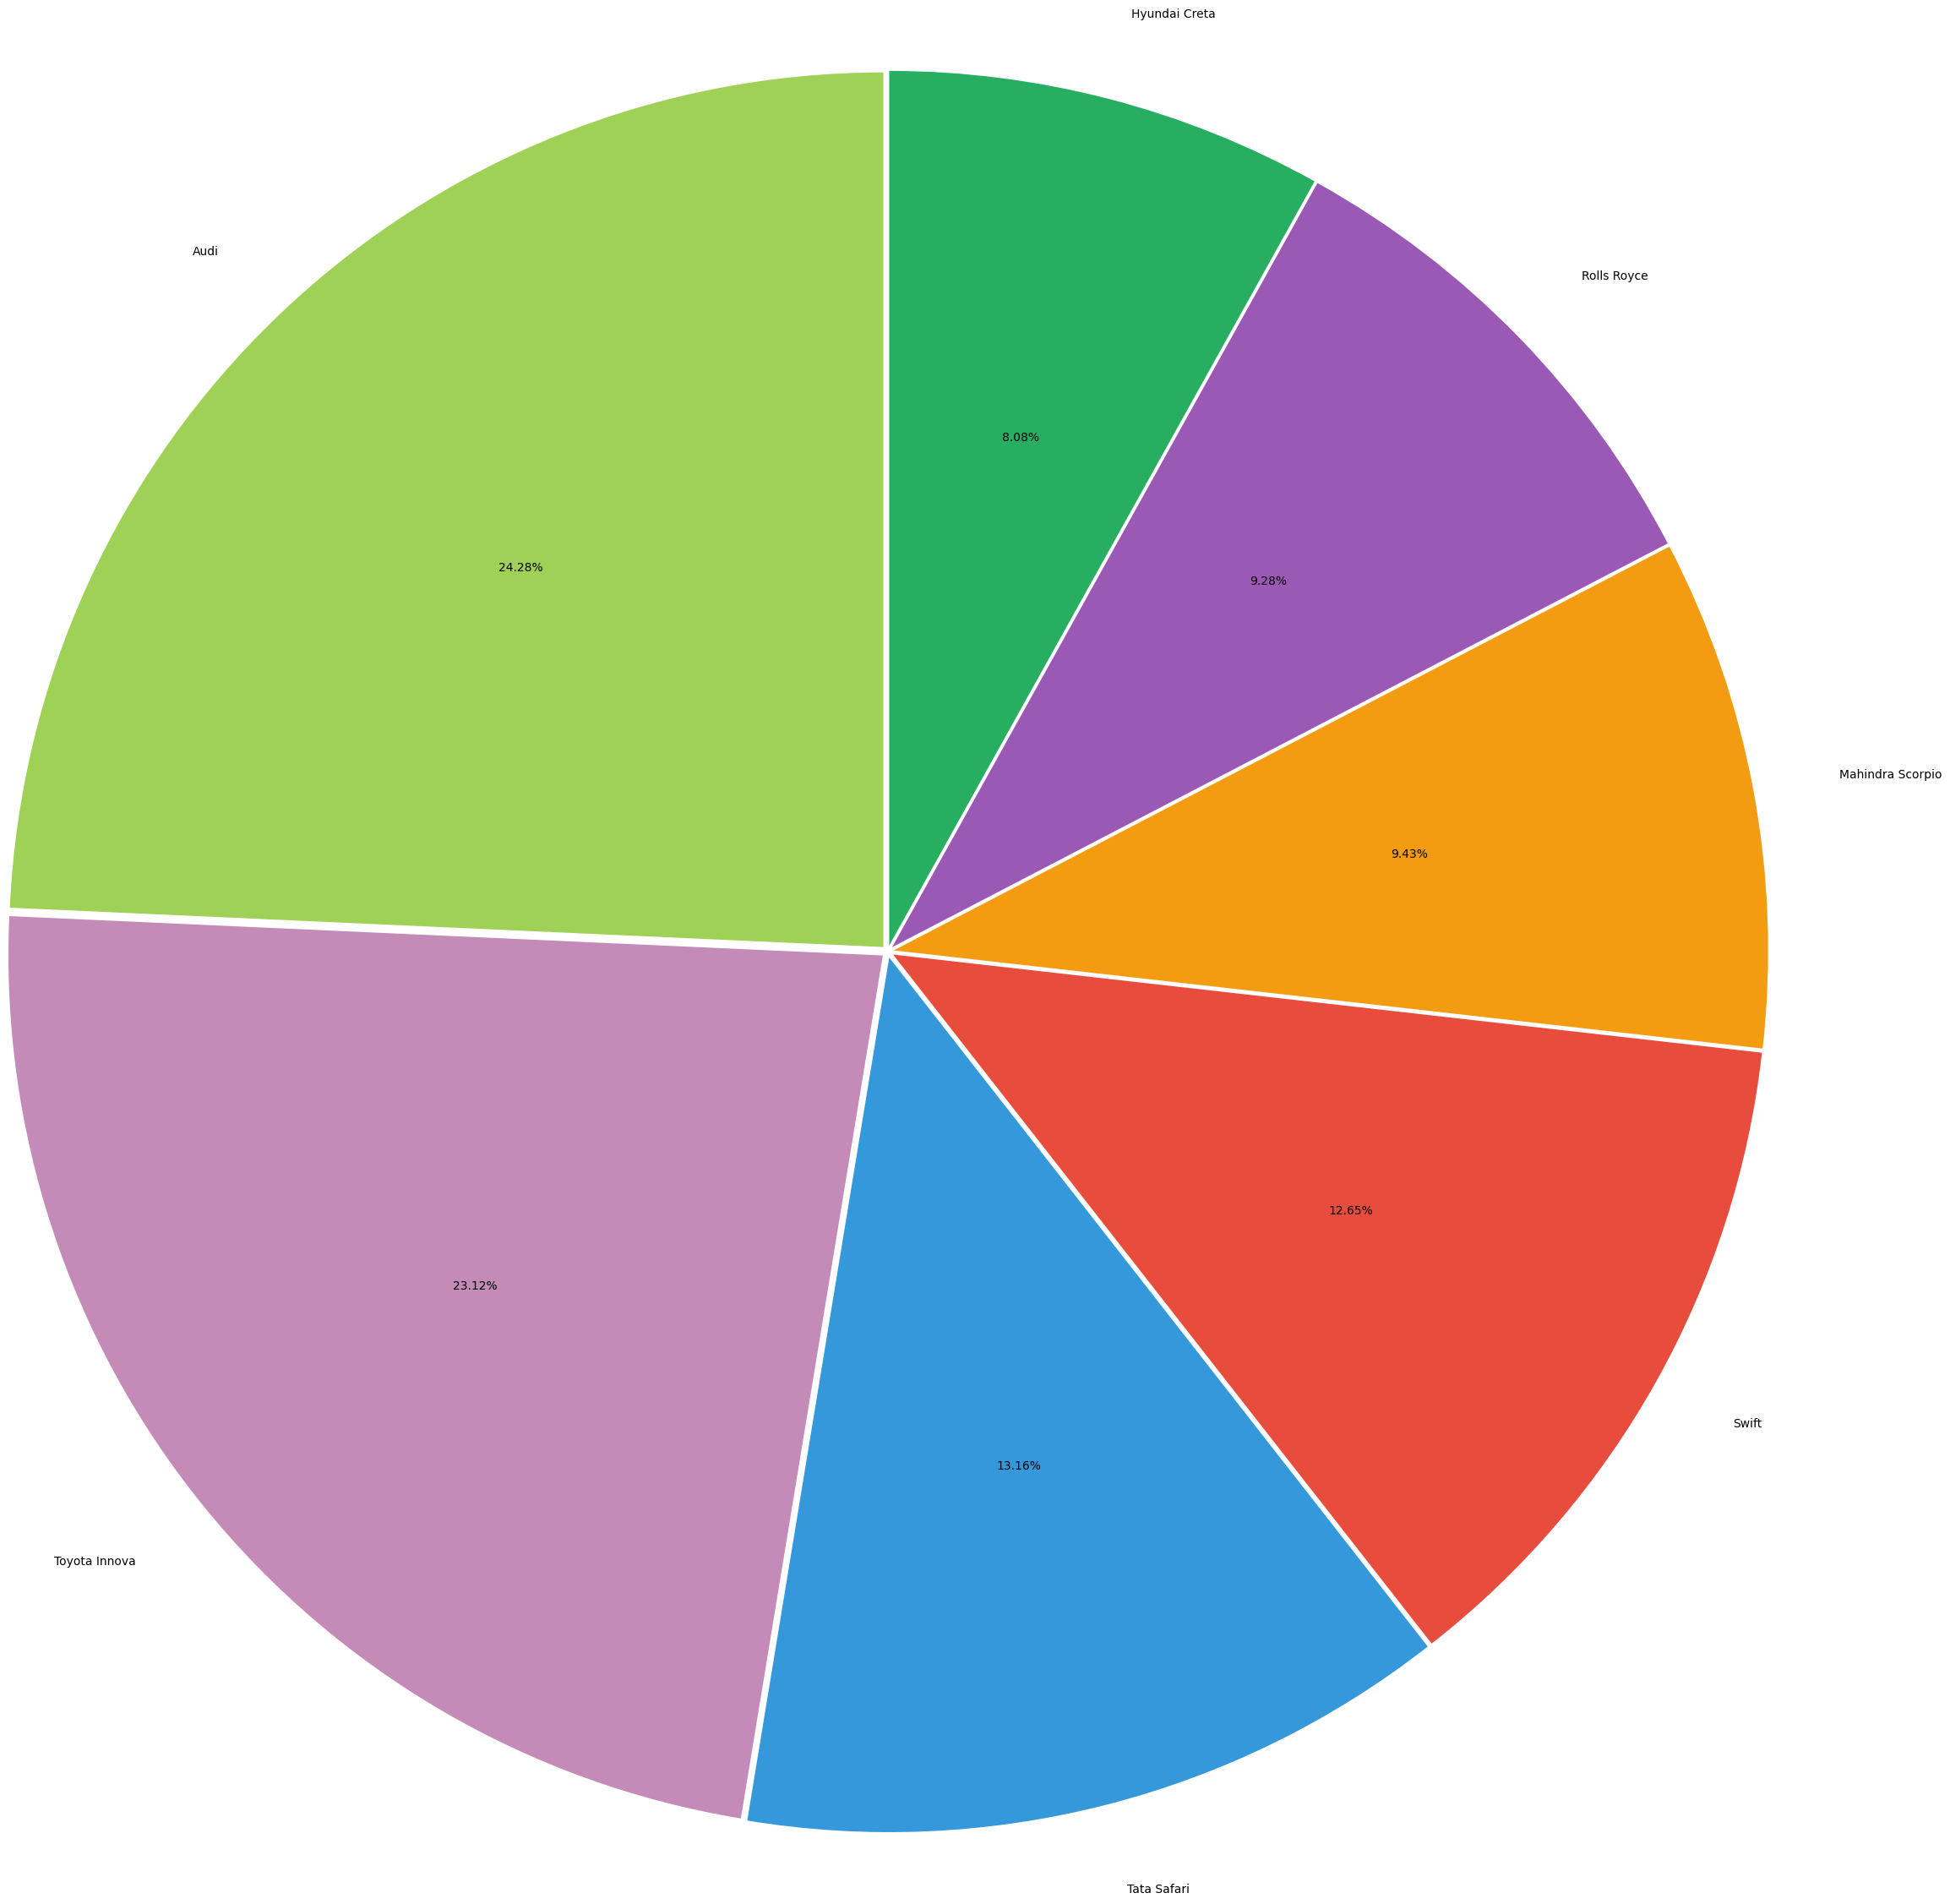

In [7]:
colors = ['#a0d157', '#c48bb8', '#3498db', '#e74c3c', '#f39c12', '#9b59b6', '#27ae60']

plt.pie(data.label.value_counts(),startangle=90,explode=[0.05,0.05,0.05,0.05,0.05,0.05,0.05],autopct='%0.2f%%',
        labels=['Audi', 'Toyota Innova','Tata Safari','Swift','Mahindra Scorpio','Rolls Royce','Hyundai Creta'], colors= colors,radius=7)
plt.show()

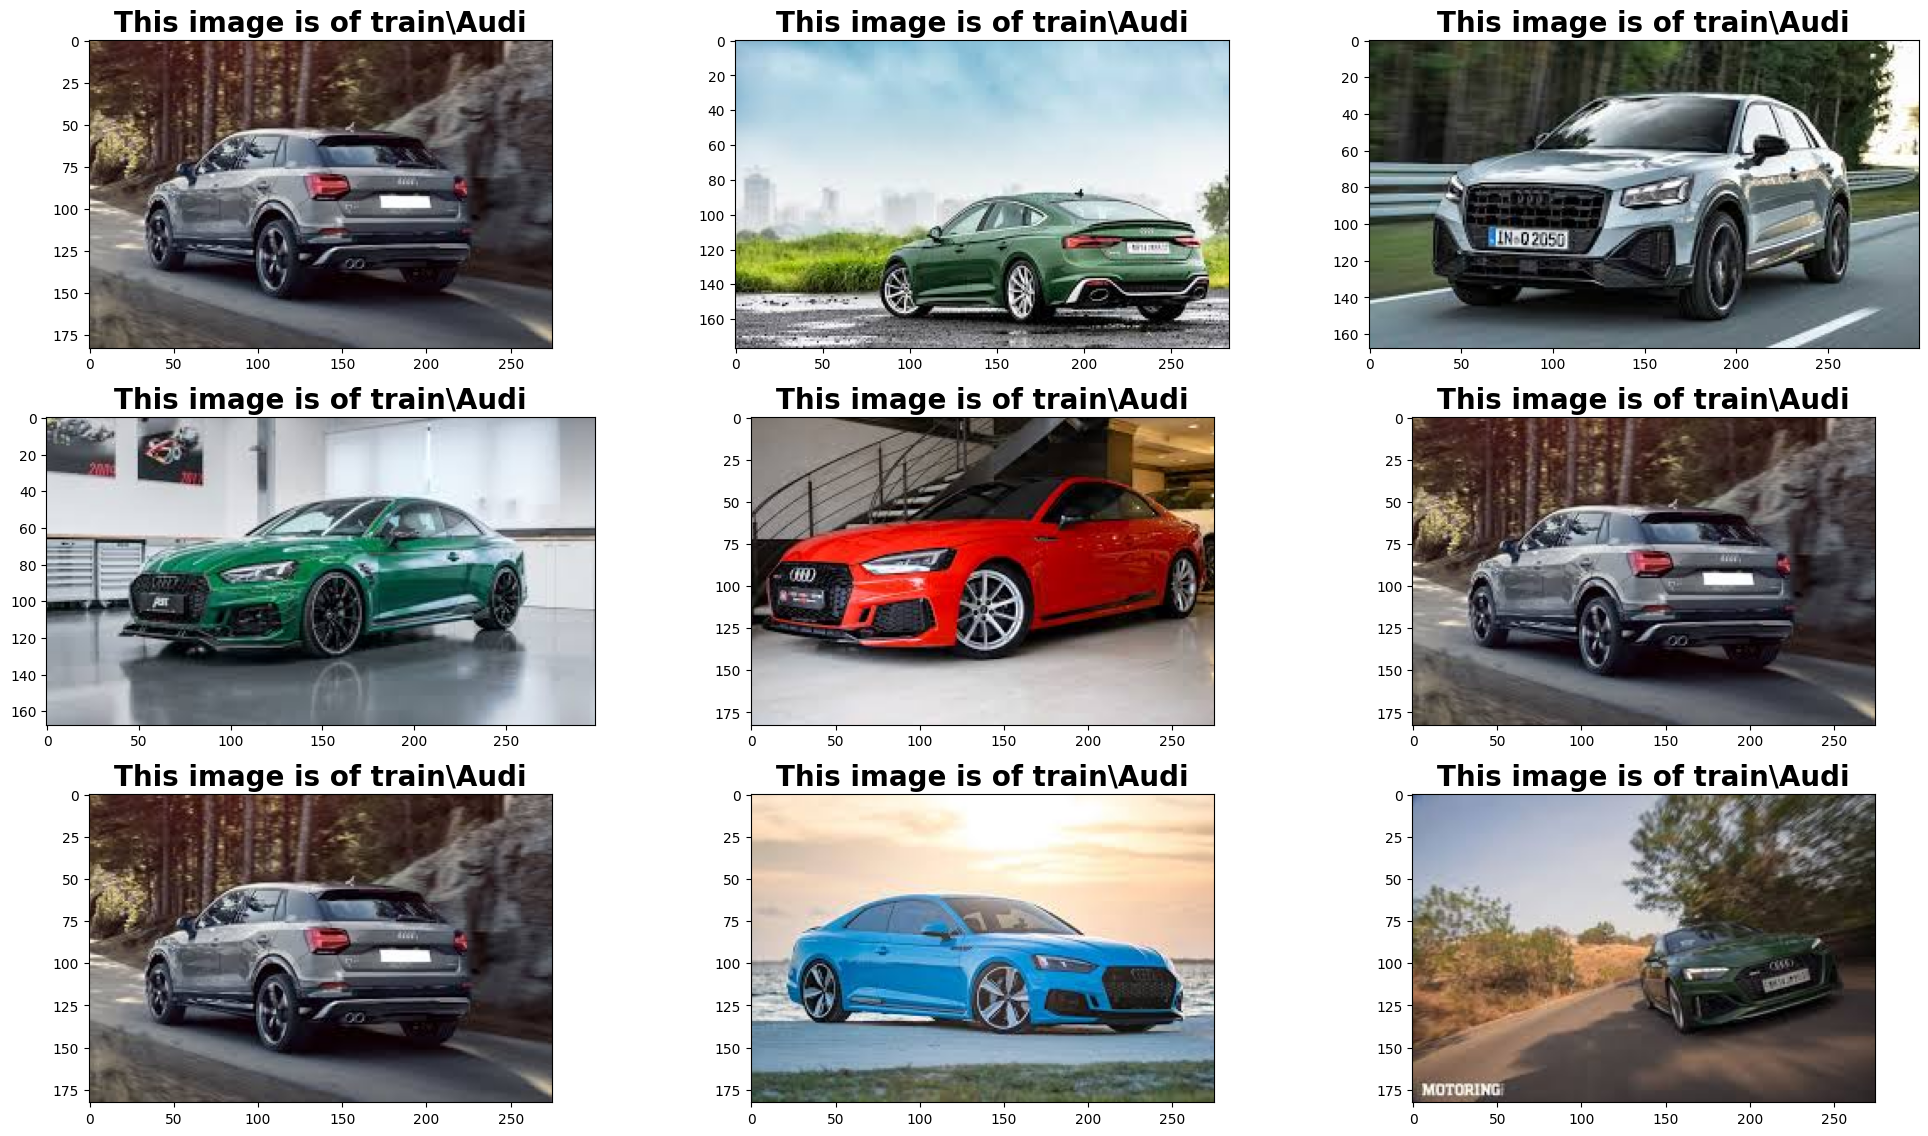

In [8]:
plt.figure(figsize=(20,15))
for i in range(9):
    plt.subplot(4,3,(i%12)+1)
    index=np.random.randint(15)
    plt.title('This image is of {0}'.format(data.label[index]),fontdict={'size':20,'weight':'bold'})
    plt.imshow(data.image[index])
    plt.tight_layout()

Sınıf Sayısının Belirlenmesi

In [9]:
className = glob(train_path + '/*' )
numberOfClass = len(className)
print("Number Of Class: ",numberOfClass)

Number Of Class:  7


Modelin Oluşturulması

In [10]:
model = Sequential()
model.add(Conv2D(32,(3,3),input_shape = (224,224,3)))
model.add(Activation("relu"))
model.add(MaxPooling2D())

model.add(Conv2D(64,(3,3)))  
model.add(Activation("relu"))
model.add(MaxPooling2D())

model.add(Conv2D(128,(3,3)))
model.add(Activation("relu"))
model.add(MaxPooling2D())

model.add(Flatten())
model.add(Dense(256))
model.add(Activation("relu"))
model.add(Dropout(0.5))
model.add(Dense(64))
model.add(Activation("relu"))
model.add(Dropout(0.5))
model.add(Dense(numberOfClass)) # output
model.add(Activation("sigmoid"))

model.compile(loss = "binary_crossentropy",optimizer = "adam",metrics = ["accuracy"])

batch_size = 256

Modelin Görselleştirilmesi

In [11]:
plot_model(model)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [12]:
train_datagen = ImageDataGenerator(rescale= 1./255)


In [13]:
test_datagen = ImageDataGenerator(rescale= 1./255)


Veri Üreticilerinin Hazırlanması

In [14]:
train_generator = train_datagen.flow_from_directory(
        train_path, 
        target_size= (224,224),
        batch_size = batch_size,
        color_mode= "rgb",
        class_mode= "categorical")

test_generator = test_datagen.flow_from_directory(
        test_path, 
        target_size= (224,224),
        batch_size = batch_size,
        color_mode= "rgb",
        class_mode= "categorical")

Found 3352 images belonging to 7 classes.
Found 813 images belonging to 7 classes.


Modelin Eğitimi

In [21]:
hist = model.fit(
x=train_generator,
epochs=50,
validation_data=test_generator
)


KeyboardInterrupt: 

In [22]:
pip install pydot

Note: you may need to restart the kernel to use updated packages.


Eğitim ve Doğrulama Sonuçlarının Görselleştirilmesi

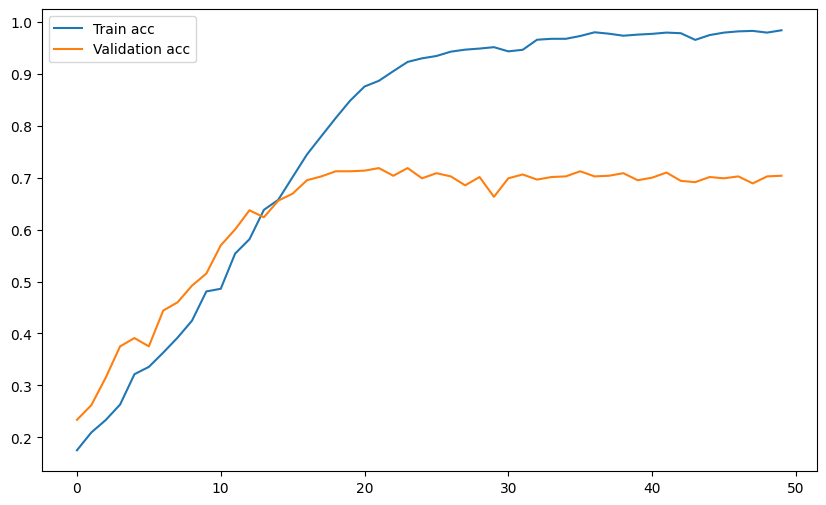

In [16]:
import matplotlib.pyplot as plt
plt.figure(figsize=[10,6])
plt.plot(hist.history["accuracy"], label = "Train acc")
plt.plot(hist.history["val_accuracy"], label = "Validation acc")
plt.legend()
plt.show()

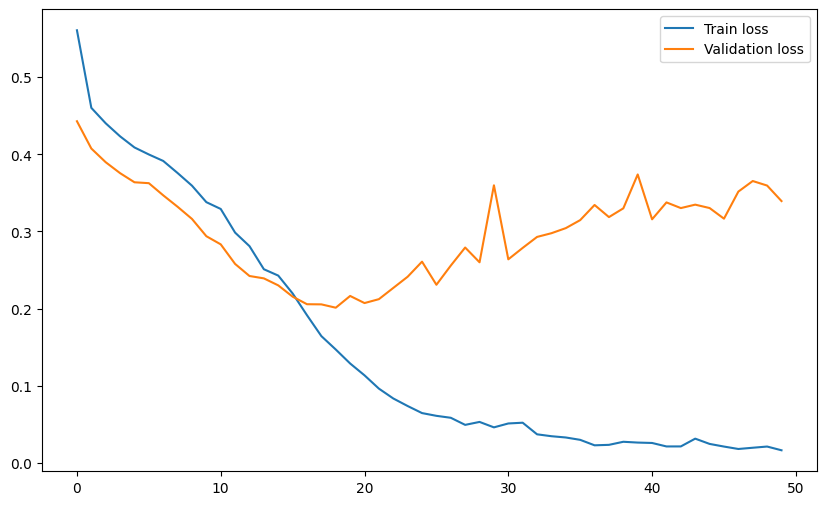

In [17]:
plt.figure(figsize=(10,6))
plt.plot(hist.history['loss'], label = "Train loss")
plt.plot(hist.history['val_loss'], label = "Validation loss")
plt.legend()
plt.show()

Tahmin Fonksiyonu


In [18]:
def predict_func(img): 
    plt.figure(figsize=(6,4))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.tight_layout()
    img = cv2.resize(img, (224, 224))
    img = np.reshape(img, [-1, 224, 224,3])
    result = np.argmax(model.predict(img))
    if result == 0: print("\033[94m"+"Araba Modeli -> Audi"+"\033[0m")
    if result ==1: print("\033[94m"+"Araba Modeli -> Hyundai Creta"+"\033[0m")
    if result ==2: print("\033[94m"+"Araba Modeli -> Mahindra Scorpio"+"\033[0m")
    if result ==3: print("\033[94m"+"Araba Modeli -> Rolls Royce"+"\033[0m")
    if result ==4: print("\033[94m"+"Araba Modeli -> Swift"+"\033[0m")
    if result ==5: print("\033[94m"+"Araba Modeli -> Tata Safari"+"\033[0m")
    if result ==6: print("\033[94m"+"Araba Modeli -> Toyota Innova"+"\033[0m")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step
Araba Modeli -> Rolls Royce


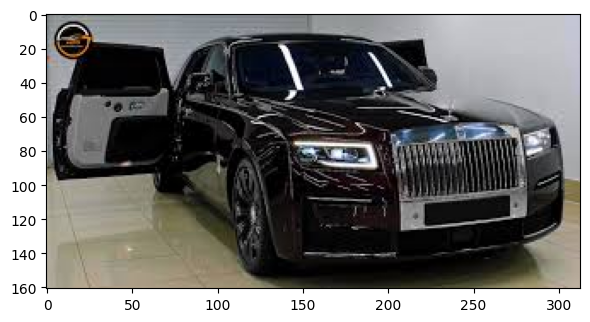

In [19]:
test_img = cv2.imread("dataset/test/Rolls Royce/159.jpg")
predict_func(test_img)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Araba Modeli -> Toyota Innova


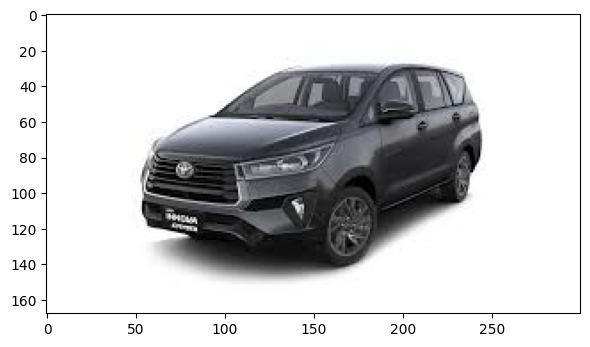

In [23]:
test_img = cv2.imread("dataset/test/Toyota Innova/21.jpg")
predict_func(test_img)